In [2]:
import tensorflow as tf

# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
#
# The value returned by the constructor represents the output
# of the Constant op.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
product = tf.matmul(matrix1, matrix2)

print(product)
print(float(product))

tf.Tensor([[12.]], shape=(1, 1), dtype=float32)
12.0


In [3]:
import tensorflow as tf

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# Add an op to subtract 'a' from 'x'.  Run it and print the result
sub = tf.subtract(x, a)
print(sub)
print(sub.numpy())
# ==> [-2. -1.]

tf.Tensor([-2. -1.], shape=(2,), dtype=float32)
[-2. -1.]


In [4]:
x.assign([4.0, 6.0])

<tf.Variable 'UnreadVariable' shape=(2,) dtype=float32, numpy=array([4., 6.], dtype=float32)>

In [5]:
sub = tf.subtract(x, a)
print(sub)
print(sub.numpy())

tf.Tensor([1. 3.], shape=(2,), dtype=float32)
[1. 3.]


In [6]:
import tensorflow as tf
import numpy as np

import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def render(a):
  a_cyclic = (a*0.3).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  return PIL.Image.fromarray(a)

#@tf.function
def mandelbrot_helper(grid_c, current_values, counts,cycles):
  
  for i in range(cycles):
    temp = current_values*current_values + grid_c
    not_diverged = tf.abs(temp) < 4
    current_values.assign(temp),
    counts.assign_add(tf.cast(not_diverged, tf.float32))

def mandelbrot(render_size,center,zoom,cycles):
  f = zoom/render_size[0]
  real_start = center[0]-(render_size[0]/2)*f
  real_end = real_start + render_size[0]*f 
  imag_start = center[1]-(render_size[1]/2)*f
  imag_end = imag_start + render_size[1]*f 

  real_range = tf.range(real_start,real_end,f,dtype=tf.float64)
  imag_range = tf.range(imag_start,imag_end,f,dtype=tf.float64)
  real, imag = tf.meshgrid(real_range,imag_range)
  grid_c = tf.constant(tf.complex(real, imag))
  current_values = tf.Variable(grid_c)
  counts = tf.Variable(tf.zeros_like(grid_c, tf.float32))

  mandelbrot_helper(grid_c, current_values,counts,cycles)
  return counts.numpy()

(640, 480)


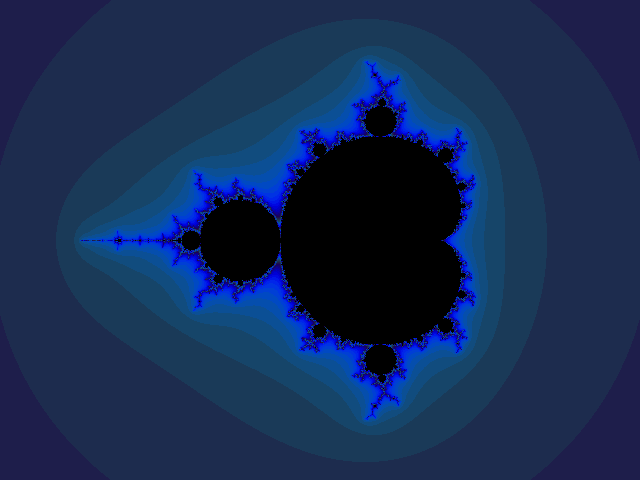

In [7]:
counts = mandelbrot(
    #render_size=(3840,2160), # 4K
    #render_size=(1920,1080), # HD
    render_size=(640,480),
    center=(-0.5,0),
    zoom=4,
    cycles=200
)  
img = render(counts)
print(img.size)
img

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
    na_values=['NA', '?'])

cars = df['name']

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Pandas to Numpy
x = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']].values
y = df['mpg'].values # regression

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

In [9]:
pred = model.predict(x)
print(f"Shape: {pred.shape}")
print(pred[0:10])

13/13 [==============================] - 0s 3ms/step
Shape: (398, 1)
[[16.453407 ]
 [10.904092 ]
 [12.260903 ]
 [12.422189 ]
 [14.280343 ]
 [ 8.245309 ]
 [ 4.0720906]
 [ 4.8199544]
 [ 3.6574178]
 [ 6.871926 ]]


In [10]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 6.506800170598647


In [11]:
# Sample predictions
for i in range(10):
    print(f"{i+1}. Car name: {cars[i]}, MPG: {y[i]}, " 
          + f"predicted MPG: {pred[i]}")

1. Car name: chevrolet chevelle malibu, MPG: 18.0, predicted MPG: [16.453407]
2. Car name: buick skylark 320, MPG: 15.0, predicted MPG: [10.904092]
3. Car name: plymouth satellite, MPG: 18.0, predicted MPG: [12.260903]
4. Car name: amc rebel sst, MPG: 16.0, predicted MPG: [12.422189]
5. Car name: ford torino, MPG: 17.0, predicted MPG: [14.280343]
6. Car name: ford galaxie 500, MPG: 15.0, predicted MPG: [8.245309]
7. Car name: chevrolet impala, MPG: 14.0, predicted MPG: [4.0720906]
8. Car name: plymouth fury iii, MPG: 14.0, predicted MPG: [4.8199544]
9. Car name: pontiac catalina, MPG: 14.0, predicted MPG: [3.6574178]
10. Car name: amc ambassador dpl, MPG: 15.0, predicted MPG: [6.871926]


In [ ]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/iris.csv", 
    na_values=['NA', '?'])

# Convert to numpy - Classification
x = df[['sepal_l', 'sepal_w', 'petal_l', 'petal_w']].values
dummies = pd.get_dummies(df['species']) # Classification
species = dummies.columns
y = dummies.values


# Build neural network
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1],activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

In [13]:
# Print out number of species found:
print(species)

Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype='object')


In [14]:
pred = model.predict(x)
print(f"Shape: {pred.shape}")
print(pred[0:10])

5/5 [==============================] - 0s 2ms/step
Shape: (150, 3)
[[9.93892074e-01 6.09503593e-03 1.28832835e-05]
 [9.78362262e-01 2.15804446e-02 5.72370845e-05]
 [9.90783095e-01 9.18632746e-03 3.06413203e-05]
 [9.84284639e-01 1.56574175e-02 5.79878360e-05]
 [9.95096624e-01 4.89201490e-03 1.14285422e-05]
 [9.96159554e-01 3.83359916e-03 6.81140409e-06]
 [9.93340790e-01 6.63283607e-03 2.64534756e-05]
 [9.91595685e-01 8.38444103e-03 1.98540492e-05]
 [9.79460835e-01 2.04439275e-02 9.52648043e-05]
 [9.80254114e-01 1.96984522e-02 4.74740991e-05]]


In [15]:
np.set_printoptions(suppress=True)

In [16]:
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y,axis=1)
print(f"Predictions: {predict_classes}")
print(f"Expected: {expected_classes}")

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Expected: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [17]:
print(species[predict_classes[1:10]])

Index(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa'],
      dtype='object')


In [18]:
from sklearn.metrics import accuracy_score

correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Accuracy: 0.98


In [19]:
sample_flower = np.array( [[5.0,3.0,4.0,2.0]], dtype=float)
pred = model.predict(sample_flower)
print(pred)
pred = np.argmax(pred)
print(f"Predict that {sample_flower} is: {species[pred]}")

1/1 [==============================] - 0s 62ms/step
[[0.02902371 0.3764072  0.5945691 ]]
Predict that [[5. 3. 4. 2.]] is: Iris-virginica


In [20]:
sample_flower = np.array( [[5.0,3.0,4.0,2.0],[5.2,3.5,1.5,0.8]],\
        dtype=float)
pred = model.predict(sample_flower)
print(pred)
pred = np.argmax(pred,axis=1)
print(f"Predict that these two flowers {sample_flower} ")
print(f"are: {species[pred]}")

1/1 [==============================] - 0s 20ms/step
[[0.02902368 0.37640724 0.5945691 ]
 [0.9910507  0.00891806 0.00003117]]
Predict that these two flowers [[5.  3.  4.  2. ]
 [5.2 3.5 1.5 0.8]] 
are: Index(['Iris-virginica', 'Iris-setosa'], dtype='object')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics

save_path = "."

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
    na_values=['NA', '?'])

cars = df['name']

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Pandas to Numpy
x = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']].values
y = df['mpg'].values # regression

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

# Predict
pred = model.predict(x)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print(f"Before save score (RMSE): {score}")

# save neural network structure to JSON (no weights)
model_json = model.to_json()
with open(os.path.join(save_path,"network.json"), "w") as json_file:
    json_file.write(model_json)

# save entire network to HDF5 (save everything, suggested)
model.save(os.path.join(save_path,"network.h5"))

In [22]:
from tensorflow.keras.models import load_model
model2 = load_model(os.path.join(save_path,"network.h5"))
pred = model2.predict(x)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print(f"After load score (RMSE): {score}")

13/13 [==============================] - 0s 3ms/step
After load score (RMSE): 4.73113615253972


In [ ]:
#03_4
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/iris.csv", 
    na_values=['NA', '?'])

# Convert to numpy - Classification
x = df[['sepal_l', 'sepal_w', 'petal_l', 'petal_w']].values
dummies = pd.get_dummies(df['species']) # Classification
species = dummies.columns
y = dummies.values

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Build neural network
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1],activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor],verbose=2,epochs=1000)

In [24]:
from sklearn.metrics import accuracy_score

pred = model.predict(x_test)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

2/2 [==============================] - 0s 4ms/step
Accuracy: 1.0


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
    na_values=['NA', '?'])

cars = df['name']

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Pandas to Numpy
x = df[['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']].values
y = df['mpg'].values # regression

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
        callbacks=[monitor], verbose=2,epochs=1000)

Epoch 1/1000
10/10 - 1s - loss: 353221.8438 - val_loss: 222426.0938 - 1s/epoch - 134ms/step
Epoch 2/1000
10/10 - 0s - loss: 158805.2812 - val_loss: 82470.2266 - 68ms/epoch - 7ms/step
Epoch 3/1000
10/10 - 0s - loss: 52320.6094 - val_loss: 22079.2871 - 67ms/epoch - 7ms/step
Epoch 4/1000
10/10 - 0s - loss: 11664.8516 - val_loss: 2710.0024 - 52ms/epoch - 5ms/step
Epoch 5/1000
10/10 - 0s - loss: 907.0444 - val_loss: 89.2007 - 53ms/epoch - 5ms/step
Epoch 6/1000
10/10 - 0s - loss: 353.1182 - val_loss: 580.4109 - 61ms/epoch - 6ms/step
Epoch 7/1000
10/10 - 0s - loss: 650.3896 - val_loss: 412.0371 - 55ms/epoch - 5ms/step
Epoch 8/1000
10/10 - 0s - loss: 345.7986 - val_loss: 131.0342 - 65ms/epoch - 6ms/step
Epoch 9/1000
10/10 - 0s - loss: 118.5014 - val_loss: 75.1532 - 67ms/epoch - 7ms/step
Epoch 10/1000
10/10 - 0s - loss: 93.6662 - val_loss: 94.0699 - 50ms/epoch - 5ms/step
Epoch 11/1000
10/10 - 0s - loss: 101.0034 - val_loss: 90.2981 - 63ms/epoch - 6ms/step
Epoch 12/1000
10/10 - 0s - loss: 94.772

In [26]:
# Measure RMSE error.  RMSE is common for regression.
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

4/4 [==============================] - 0s 4ms/step
Final score (RMSE): 8.151364763782563


In [1]:
# 03_5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np

# Create a dataset for the XOR function
x = np.array([
    [0,0],
    [1,0],
    [0,1],
    [1,1]
])

y = np.array([
    0,
    1,
    1,
    0
])

# Build the network
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

done = False
cycle = 1

while not done:
    print("Cycle #{}".format(cycle))
    cycle+=1
    model = Sequential()
    model.add(Dense(2, input_dim=2, activation='relu')) 
    model.add(Dense(1)) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x,y,verbose=0,epochs=10000)

    # Predict
    pred = model.predict(x)
    
    # Check if successful.  It takes several runs with this 
    # small of a network
    done = pred[0]<0.01 and pred[3]<0.01 and pred[1] > 0.9 \
        and pred[2] > 0.9 
    print(pred)

Cycle #1
1/1 [==============================] - 1s 687ms/step
[[6.6666663e-01]
 [6.6666663e-01]
 [6.6666663e-01]
 [5.9604645e-08]]
Cycle #2
1/1 [==============================] - 0s 60ms/step
[[0.3333333]
 [1.       ]
 [0.3333333]
 [0.3333333]]
Cycle #3
1/1 [==============================] - 0s 89ms/step
[[0.49999997]
 [0.49999997]
 [1.        ]
 [0.        ]]
Cycle #4
1/1 [==============================] - 0s 72ms/step
[[0.3333333 ]
 [0.3333333 ]
 [0.99999994]
 [0.3333333 ]]
Cycle #5


1/1 [==============================] - 0s 64ms/step
[[4.9999985e-01]
 [1.0000000e+00]
 [4.9999985e-01]
 [1.1920929e-07]]
Cycle #6


1/1 [==============================] - 0s 61ms/step
[[0.49999997]
 [0.49999997]
 [0.49999997]
 [0.49999997]]
Cycle #7
1/1 [==============================] - 0s 61ms/step
[[2.4207569e-05]
 [1.0000422e+00]
 [1.0000442e+00]
 [3.5174824e-05]]


In [2]:
# Dump weights
for layerNum, layer in enumerate(model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} \
                  -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

0B -> L1N0: -1.346900224685669
0B -> L1N1: -0.0002561513101682067
L0N0                   -> L1N0 = 1.3459833860397339
L0N0                   -> L1N1 = 0.8610692620277405
L0N1                   -> L1N0 = 1.346782922744751
L0N1                   -> L1N1 = 0.8610709309577942
1B -> L2N0: 2.420756936771795e-05
L1N0                   -> L2N0 = -1.4862734079360962
L1N1                   -> L2N0 = 1.1617133617401123


In [3]:
input0 = 0
input1 = 1

hidden0Sum = (input0*1.3)+(input1*1.3)+(-1.3)
hidden1Sum = (input0*1.2)+(input1*1.2)+(0)

print(hidden0Sum) # 0
print(hidden1Sum) # 1.2

hidden0 = max(0,hidden0Sum)
hidden1 = max(0,hidden1Sum)

print(hidden0) # 0
print(hidden1) # 1.2

outputSum = (hidden0*-1.6)+(hidden1*0.8)+(0)
print(outputSum) # 0.96

output = max(0,outputSum)

print(output) # 0.96

0.0
1.2
0
1.2
0.96
0.96
